<a href="https://colab.research.google.com/github/Projet4A/Projet4AINT201/blob/Thomas/P4A_Piotrowski/P4A_ML_com.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importations**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split #Données d'entrainement et test avec les mêmes fonctionnements (moy et ecart-type).
from sklearn.preprocessing import OneHotEncoder #["homme", "femme"] -> [[1,0],[0,1]]
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn import svm
from sklearn.compose import make_column_transformer #Méthode pour transformer
from sklearn.model_selection import GridSearchCV #Cherche le meilleur modèle en fonction des paramètres donnés.
from sklearn.feature_selection import SelectKBest
import seaborn as sns #Pour les graphes
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pickle
from xgboost import plot_importance #Se base sur la création des arbres de décision.
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder #Plutot pour les vatiables de rang.
from xgboost import plot_tree #Affichage des arbres.
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# **Load Data**

In [5]:
#Load data from the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Traitement des données**

In [6]:
data = pd.read_csv('/content/drive/MyDrive/Data/ClientA_Data_NC.csv')
data.RPM.fillna(data.RPM.mean(),inplace=True) #On accède à la colonne et remplissage des valeurs manquantes par la moyenne des valeurs existantes.

encodeur = LabelEncoder()
Y=encodeur.fit_transform(data.FaultStatus) #On s'entraine et transforme les données.
X=data.drop(['DateTime_x','Bearing_Location','Date','EquipmentID','SurveyDate','EquipmentName','AnalysisDate','FaultStatus','FaultName','Comment','Location','Analyst','AreaID','Route','EquipmentName'],axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2, random_state=42) #80% entrainement et 20% test / une valeur(42) pour l'aléatoire.

numerical_features = ['DataValue','RPM','Units']
categorical_features = ['EquipmentClassification','Description_Area','Description_Equipment','MptID','Description_MeasPt','Description_APSet','Description_AnalParm','AreaName']

numerical_pipeline = make_pipeline(StandardScaler()) #Ce qu'on applique aux variables numérique.
categorical_pipeline = make_pipeline(OneHotEncoder(categories='auto',sparse=False,handle_unknown = 'ignore'))

transformer = make_column_transformer((numerical_pipeline, numerical_features),(categorical_pipeline,categorical_features)) #Création de couples / couloir de transformation.

# **Modèles Machine Learning**

# Project the data onto the 2 primary principal components

X_bis?

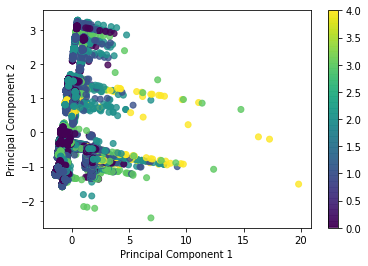

In [7]:
pca = PCA(2)
X_projected = pca.fit_transform(transformer.fit_transform(X))

x1 = X_projected[:, 0]
x2 = X_projected[:, 1]

fig = plt.figure()
plt.scatter(x1, x2,
        c=Y, alpha=0.8,
        cmap='viridis')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()

plt.show()

# Classification

### Random Forest Classification (RFC)

In [ ]:
RFC = make_pipeline(transformer,RandomForestClassifier(n_estimators=100))
RFC.fit(X_train,Y_train)
y_pred_rfc = RFC.predict(X_test)
y_true_ = Y_test.ravel()

recall_res_rfc = recall_score(y_true_, y_pred_rfc, average=None)
precision_res_rfc = precision_score(y_true_, y_pred_rfc, average=None)
f1score_res_rfc = f1_score(y_true_, y_pred_rfc, average=None)
acc_res_rfc = accuracy_score(y_true_, y_pred_rfc)

### Support Vector Machine Classifier

In [ ]:
SVC = make_pipeline(transformer,svm.SVC(kernel='rbf', C=1))
SVC.fit(X_train,Y_train)
y_pred_svc = SVC.predict(X_test)
y_true_ = Y_test.ravel()

recall_res_svc = recall_score(y_true_, y_pred_svc, average=None)
precision_res_svc = precision_score(y_true_, y_pred_svc, average=None)
f1score_res_svc = f1_score(y_true_, y_pred_svc, average=None)
acc_res_svc = accuracy_score(y_true_, y_pred_svc)

### XBOOST Regressor Classifier (XGBC)

In [ ]:
XGBC = make_pipeline(transformer,xgb.XGBClassifier(n_estimators=100))
XGBC.fit(X_train, Y_train)
y_pred_xgbc = XGBC.predict(X_test)
y_true_ = Y_test.ravel()

recall_res_xgbc = recall_score(y_true_, y_pred_xgbc, average=None)
precision_res_xgbc = precision_score(y_true_, y_pred_xgbc, average=None)
f1score_res_xgbc = f1_score(y_true_, y_pred_xgbc, average=None)
acc_res_xgbc = accuracy_score(y_true_, y_pred_xgbc)

confusion_mat_xgbc = confusion_matrix(y_true_, y_pred_xgbc)
fig, ax = plt.subplots()
sns.heatmap(data=confusion_mat_xgbc, annot=True, fmt='d', cmap="YlGnBu",
            square=True, linewidths=.5, cbar_kws={"shrink": .70})
ax.set_ylim(len(encodeur.classes_),0)
ax.set_title('Confusion matrix of XGBC (n_estimators = 100)')
ax.tick_params(axis='both',pad=15)
ax.set_xlabel('Predicted')
ax.set_xticklabels(encodeur.classes_,fontdict = {'horizontalalignment': 'center'},rotation=90)
ax.set_ylabel('Actually')
ax.set_yticklabels(encodeur.classes_,fontdict = {'verticalalignment': 'center'},rotation=360)

result = permutation_importance(XGBC, X_test, Y_test, n_repeats=10,random_state=42, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()
fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances XGBC(test set)")
fig.tight_layout()
plt.show()

prob = XGBC.predict_proba(X_test)
fig, ax = plt.subplots(1,1)
rep = (y_true_-y_pred_xgbc)
l = np.array([i for i,x in enumerate(rep) if x!=0])
sns.distplot(prob[l].max(axis=1))
sns.distplot(prob[~l].max(axis=1))

fig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_tree(XGBC['xgbclassifier'], num_trees=4, ax=ax)
plt.show()

file_name = "xgb_cla_fsall.pkl"
# save
pickle.dump(XGBC, open(file_name, "wb"))
# load
XGBC = pickle.load(open(file_name, "rb"))

KeyboardInterrupt: ignored

### KNeighbors Classifier (KNC)

In [ ]:
KNC = make_pipeline(transformer,KNeighborsClassifier(n_neighbors=10))
KNC.fit(X_train, Y_train)
y_pred_knc = KNC.predict(X_test)
y_true_ = Y_test.ravel()

recall_res_knc = recall_score(y_true_, y_pred_knc, average=None)
precision_res_knc = precision_score(y_true_, y_pred_knc, average=None)
f1score_res_knc = f1_score(y_true_, y_pred_knc, average=None)
acc_res_knc = accuracy_score(y_true_, y_pred_knc)

### Logistic Regression (LR)

In [ ]:
LR = make_pipeline(transformer,LogisticRegression())
LR.fit(X_train, Y_train)
y_pred_lr = LR.predict(X_test)
y_true_ = Y_test.ravel()

recall_res_lr = recall_score(y_true_, y_pred_lr, average=None)
precision_res_lr = precision_score(y_true_, y_pred_lr, average=None)
f1score_res_lr = f1_score(y_true_, y_pred_lr, average=None)
acc_res_lr = accuracy_score(y_true_, y_pred_lr)

# Stacking

In [ ]:
# # compare ensemble to each baseline classifier
# from numpy import mean
# from numpy import std
# from sklearn.datasets import make_classification
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.svm import SVC
# from sklearn.naive_bayes import GaussianNB
# from sklearn.ensemble import StackingClassifier
# from matplotlib import pyplot
#
# # get the dataset
# def get_dataset():
# 	X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1)
# 	return X, y
#
# # get a stacking ensemble of models
# def get_stacking():
# 	# define the base models
# 	level0 = list()
# 	level0.append(('lr', LogisticRegression()))
# 	level0.append(('knn', KNeighborsClassifier()))
# 	level0.append(('cart', DecisionTreeClassifier()))
# 	level0.append(('svm', SVC()))
# 	level0.append(('bayes', GaussianNB()))
# 	# define meta learner model
# 	level1 = LogisticRegression()
# 	# define the stacking ensemble
# 	model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
# 	return model
#
# # get a list of models to evaluate
# def get_models():
# 	models = dict()
# 	models['lr'] = LogisticRegression()
# 	models['knn'] = KNeighborsClassifier()
# 	models['cart'] = DecisionTreeClassifier()
# 	models['svm'] = SVC()
# 	models['bayes'] = GaussianNB()
# 	models['stacking'] = get_stacking()
# 	return models
#
# # evaluate a give model using cross-validation
# def evaluate_model(model, X, y):
# 	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# 	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# 	return scores
#
# # define dataset
# X, y = get_dataset()
# # get the models to evaluate
# models = get_models()
# # evaluate the models and store results
# results, names = list(), list()
# for name, model in models.items():
# 	scores = evaluate_model(model, X, y)
# 	results.append(scores)
# 	names.append(name)
# 	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# # plot model performance for comparison
# pyplot.boxplot(results, labels=names, showmeans=True)
# pyplot.show()
#
# # make a prediction with a stacking ensemble
# from sklearn.datasets import make_classification
# from sklearn.ensemble import StackingClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.svm import SVC
# from sklearn.naive_bayes import GaussianNB
# # define dataset
# X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1)
# # define the base models
# level0 = list()
# level0.append(('lr', LogisticRegression()))
# level0.append(('knn', KNeighborsClassifier()))
# level0.append(('cart', DecisionTreeClassifier()))
# level0.append(('svm', SVC()))
# level0.append(('bayes', GaussianNB()))
# # define meta learner model
# level1 = LogisticRegression()
# # define the stacking ensemble
# model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
# # fit the model on all available data
# model.fit(X, y)
# # make a prediction for one example
# data = [[2.47475454,0.40165523,1.68081787,2.88940715,0.91704519,-3.07950644,4.39961206,0.72464273,-4.86563631,-6.06338084,-1.22209949,-0.4699618,1.01222748,-0.6899355,-0.53000581,6.86966784,-3.27211075,-6.59044146,-2.21290585,-3.139579]]
# yhat = model.predict(data)
# print('Predicted Class: %d' % (yhat))

###

# model = make_pipeline(transformer,RandomForestClassifier())
# param_grid = {'randomforestclassifier__n_estimators':np.arange(20,21)}
# grid = GridSearchCV(model,param_grid,cv=5)
# grid.fit(X_train,Y_train)
# model = grid.best_estimator_
# b = model.score(X_train,Y_train)
# y_pred_ = model.predict(X_test)
# y_true_ = Y_test.ravel()
#
# recall_res = recall_score(y_true_, y_pred_, average=None)
# precision_res = precision_score(y_true_, y_pred_, average=None)
# f1score_res = f1_score(y_true_, y_pred_, average=None)
# acc_res = accuracy_score(y_true_, y_pred_)
#
# confusion_mat = confusion_matrix(y_true_, y_pred_)
# fig, ax = plt.subplots()
# sns.heatmap(data=confusion_mat, annot=True, fmt='d')
# ax.set_ylim(2,0)
# ax.set_title('Confusion matrix of XGBOOST')
# ax.set_xticklabels(['Intervention','No intervention'])

# plt.figure(figsize=(10,5))
# plt.rcParams.update({'font.size': 12})
# sns.distplot(y_true, label='True values')
# sns.distplot(y_pred, label='Predictions')
# plt.title('Distribution of the number of days')
# plt.xlabel('Number of days', fontsize=12)
# plt.legend()
# plt.show()

# fs = SelectKBest(score_func=f_regression, k='all')
# fs.fit(X_train[numerical_features], Y_train)
# X_train_fs = fs.transform(X_train)
# X_test_fs = fs.transform(X_test)

# rf = RandomForestRegressor(n_estimators = 100,
#                            n_jobs = -1,
#                            oob_score = True,
#                            bootstrap = True,
#                            random_state = 42)
#
# model = make_pipeline(transformer,rf)
# model.fit(X_train,Y_train)
#
# print('\nR^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(model.score(X_train, Y_train),
#                                                                                              model['randomforestregressor'].oob_score_,
#                                                                                              model.score(X_test, Y_test)))
#
# feature_list = model['columntransformer'].transformers_[0][2] + list(model['columntransformer'].transformers_[1][1]['onehotencoder'].get_feature_names(categorical_features)) + [s+'_ant_dp' for s in model['columntransformer'].transformers_[2][1]['countvectorizer'].get_feature_names()] + [s+'_ant_das' for s in model['columntransformer'].transformers_[3][1]['countvectorizer'].get_feature_names()]+[s+'_dp' for s in model['columntransformer'].transformers_[4][1]['countvectorizer'].get_feature_names()]
# importances = model['randomforestregressor'].feature_importances_
# sns.barplot(x=feature_list, y=importances)
# plt.title('Feature importance in random forest')
# plt.xticks(rotation=90)
# plt.tight_layout()
#
# from sklearn.inspection import permutation_importance
# result = permutation_importance(model, X_test, Y_test, n_repeats=10,
#                                 random_state=42, n_jobs=-1)
# sorted_idx = result.importances_mean.argsort()
#
# fig, ax = plt.subplots()
# ax.boxplot(result.importances[sorted_idx].T,
#             vert=False, labels=X_test.columns[sorted_idx])
# ax.set_title("Permutation Importances (test set)")
# fig.tight_layout()
# plt.show()

# Import tools needed for visualization
# from sklearn import tree
# feature_list = model['columntransformer'].transformers_[0][2] + list(model['columntransformer'].transformers_[1][1]['onehotencoder'].get_feature_names(categorical_features)) + model['columntransformer'].transformers_[2][1]['countvectorizer'].get_feature_names() + model['columntransformer'].transformers_[3][1]['countvectorizer'].get_feature_names()
# tree_rf = model['randomforestregressor'].estimators_[5]
# fig = plt.figure(figsize = (100,100))
# tree.plot_tree(tree_rf,
#                 feature_names = feature_list,
#                 class_names=['los'],
#                 max_depth = 3,
#                 filled = True,
#                 fontsize = 1);
# fig.savefig('rf_individualtree.png')

# model = make_pipeline(transformer,xgb.XGBClassifier(n_estimators=100))
# model.fit(X_train, Y_train)
# print("\nXGBoost obtient un score de {}% sur les données d'entrainement.".format(100*model.score(X_train, Y_train)))
# print("XGBoost obtient un score de {}% sur les données de test.".format(100*model.score(X_test,Y_test)))

#
# neigh = make_pipeline(transformer,KNeighborsRegressor(n_neighbors=50))
# neigh.fit(X_train, Y_train)
# print("\nKNNR obtient un score de {}% sur les données d'entrainement.".format(100*neigh.score(X_train, Y_train)))
# print("KNNR obtient un score de {}% sur les données de test.".format(100*neigh.score(X_test,Y_test)))